In [1]:
from scipy.signal import chirp
import numpy as np
from matplotlib import pyplot as plt
import math
import os
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
os.chdir("/Users/liutianlin/Desktop/Academics/MINDS/neuromorphic")
import matplotlib.pyplot as plot

import numpy as np
from matplotlib import pyplot as plt
import h5py
import DYNAPSETools.dynapseSpikesFitter as fitter

folderName = "/Users/liutianlin/Desktop/Academics/MINDS/neuromorphic/caer/myoutputs/thesis_output_aedat/"


plt.close('all')

fileList = ['baselineBias_classificationRes_seqPulse', 'classificationBias_slowClassificationRes_seqPulse']
    

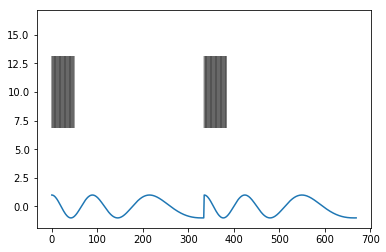

In [2]:
tEnd = 3.35
t = np.linspace(0, tEnd, 335)
w = chirp(t, f0= 1.25, f1= 0.25, t1= tEnd, method='linear') # the chirp signal
# w = chirp(t, f0= 6.25, f1= 0.25, t1= tEnd, method='linear') # the chirp signal

u = 2* np.concatenate((np.ones([1,50])[0], np.zeros((1,285))[0])) # the input pulse

repeatTime = 30
periodicChirpList = [w]
pulseSigList = [u]

for i in np.arange(repeatTime - 1):
    periodicChirpList.append(w)
    pulseSigList.append(u)

periodicChirp = np.array(periodicChirpList).flatten()    
pulseSig = np.array(pulseSigList).flatten()    

plot.eventplot(np.where(pulseSig[:2*335] == 2)[0], lineoffsets = 10, linelengths = 6.27, linewidths = 0.4, color = 'k')     


plt.plot(periodicChirp[:2*335])
# plt.plot(pulseSig[:2*335])
mse_train_dict = {}
mse_test_dict = {}

prediction_train_dict = {}
prediction_test_dict = {}

In [7]:
alphas ={}
alphas['baselineBias_classificationRes_seqPulse'] = 0.10
alphas['classificationBias_slowClassificationRes_seqPulse'] = 40

washoutLength = 200

data_dict = {}
for this_File in fileList:

    print(this_File)

    trainDataset = this_File + '.hdf5'

    fileName = os.path.join(folderName, trainDataset)
    h5f = h5py.File(fileName, "r")
    importedData = h5f["data"][:]
    h5f.close()

    data = np.concatenate(importedData, axis = 1)

    
    data = data[:, :len(periodicChirp)] # match the size of input and target 
    data_dict[this_File] = data

    nonzeroNeuronIndices = np.where(np.sum(data, axis = 1) > 1e-10)[0] 
    data = data[nonzeroNeuronIndices, :]

    trainTestSplit = int(3*len(periodicChirp)/4)

    trainData = data[:, washoutLength:trainTestSplit]
    testData = data[:, trainTestSplit:]

    trainTarget = periodicChirp[washoutLength:trainTestSplit]
    testTarget = periodicChirp[trainTestSplit:]

    # target = periodicChirp
    alpha  = alphas[this_File]
    regr = linear_model.Ridge(alpha = alpha) # carry out linear regression

    regr.fit(trainData.T, trainTarget.T)
    coefficients = regr.coef_

    prediction_train = fitter.sklearn_prevision(regr = regr, matrix = trainData)
    prediction_test = fitter.sklearn_prevision(regr = regr, matrix = testData)


    prediction_train_dict[this_File] = prediction_train
    prediction_test_dict[this_File] = prediction_test

    mse_train_dict[this_File] = round(mean_squared_error(prediction_train, trainTarget),2)

    mse_test_dict[this_File] = round(mean_squared_error(prediction_test, testTarget),2)



    print(mse_train_dict[this_File])

    print(mse_test_dict[this_File])

baselineBias_classificationRes_seqPulse
0.41
0.48
classificationBias_slowClassificationRes_seqPulse
0.14
0.38


# Visualize results

## Reservoir Response

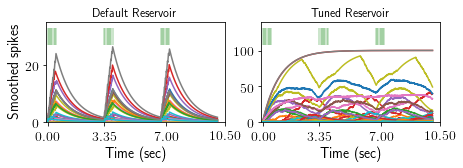

In [13]:
import random
random.seed(1)


plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=14)

width = 6.37
# height = width / 1.618 /2
height = width / 1.5 /2



inputSpikes = np.array([])
nrPeriods = 3

for i in np.arange(nrPeriods):
    inputSpikes = np.concatenate((inputSpikes, np.linspace(0, 0.5, 8) + i * 3.35 ))

    

fig = plt.figure()


ax1 = fig.add_subplot(121)

ax1.set_xlabel('Time (sec)')
ax1.set_ylabel('Smoothed spikes')
ax1.set_ylim([-0.1, 35])
ax1.set_xlim([-0.1, 10.5])
ax1.set_xticks([0, 3.35, 7.0, 10.5])
ax1.eventplot(inputSpikes, lineoffsets = 30, linelengths = 6, linewidths = 0.4, color = 'g')     
ax1.set_title('Default Reservoir')

ax2 = fig.add_subplot(122)
ax2.set_ylim([-0.1, 140])
ax2.set_xlim([-0.1, 10.5])

ax2.set_xlabel('Time (sec)')
ax2.set_xticks([0, 3.35, 7.0, 10.5])
ax2.eventplot(inputSpikes, lineoffsets = 120, linelengths = (140/35)*6, linewidths = 0.4, color = 'g')     
ax2.set_title('Tuned Reservoir')


thisSicMat = data_dict[fileList[0]]
bins = np.arange(thisSicMat.shape[1])

plotRange = int(3.35 * 100) * nrPeriods

randNeuronIndices = random.sample(range(0, 255), 50)

for i in randNeuronIndices:
    ax1.plot((bins * 0.01)[:plotRange], data_dict[fileList[0]][i,:][:plotRange])
    ax2.plot((bins * 0.01)[:plotRange], data_dict[fileList[1]][i,:][:plotRange])

# plt.subplots_adjust(wspace=0.2)
fig.subplots_adjust(left=.09, bottom=.25, right=.95, top=0.9)
fig.set_size_inches(width, height)

plt.gcf().savefig('/Users/liutianlin/Desktop/Academics/MSc_thesis/my_msc_thesis/figs/thesis_regression_visualization.pdf', dpi=1200)
plt.show()



## Training result

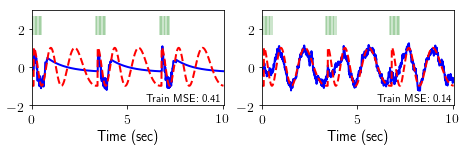

In [86]:
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=14)

# plt.rcParams.update({'font.size': 22})
width = 6.37
height = width / 2/ 1.618 
fig = plt.figure()
# fig.subplots_adjust(left=.06, bottom=.16, right=.99, top=.97)
ax1 = fig.add_subplot(121)

nrPeriods = 3

shift = 125

ax1.plot(np.arange(nrPeriods * 335)/100, prediction_train_dict[fileList[0]][shift:shift+nrPeriods * 335], color = 'b',linewidth = 2)
ax1.plot(np.arange(nrPeriods * 335)/100, trainTarget[shift: shift + nrPeriods * 335], linestyle = '--', color = 'red', linewidth = 2)


inputSpikes = np.array([])

for i in np.arange(nrPeriods):
    inputSpikes = np.concatenate((inputSpikes, np.linspace(0, 0.5, 8) + i * 3.35 ))

ax1.eventplot(inputSpikes, lineoffsets = 2.2, linelengths = 1, linewidths = 0.4, color = 'g')     



ax1.set_ylim([-2, 3])
ax1.set_xlim([0, 10.05])
ax1.set_xlabel('Time (sec)')
ax1.text(6, -1.8, 'Train MSE: ' + str(mse_train_dict[fileList[0]]), fontsize=11)

# ax1.set_ylabel('Time (sec)')

shift = 125
ax2 = fig.add_subplot(122)
ax2.plot(np.arange(nrPeriods * 335)/100, prediction_train_dict[fileList[1]][shift:shift + nrPeriods * 335], color = 'b', linewidth = 2)
ax2.plot(np.arange(nrPeriods * 335)/100, trainTarget[shift: shift + nrPeriods * 335], linestyle = '--', color = 'red',  linewidth = 2)
# ax2.plot(np.arange(nrPeriods * 335)/100, pulseSig[:nrPeriods * 335], linestyle = '-', color = 'g', linewidth = 2)
# ax2.eventplot(np.where(pulseSig[:nrPeriods*335] == 2)[0]/100, lineoffsets = 2.2, linelengths = 1, linewidths = 0.4, color = 'k')     
ax2.eventplot(inputSpikes, lineoffsets = 2.2, linelengths = 1, linewidths = 0.4, color = 'g')     

ax2.set_ylim([-2, 3])
ax2.set_xlim([0, 10.05])
ax2.text(6, -1.8, 'Train MSE: ' + str(mse_train_dict[fileList[1]]), fontsize=11)

ax2.set_xlabel('Time (sec)')


fig.set_size_inches(width, height)
# fig.subplots_adjust(left=.04, bottom=.05, right=.98, top=.97)

fig.subplots_adjust(left=.06, right=.98, top=.97, bottom = 0.3, wspace=0.2)


# plt.subplots_adjust(bottom = 0.3, wspace=0.1)
plt.gcf().savefig('/Users/liutianlin/Desktop/Academics/MSc_thesis/my_msc_thesis/figs/thesis_regression_train.pdf', dpi=1200)
plt.show()

## Testing result

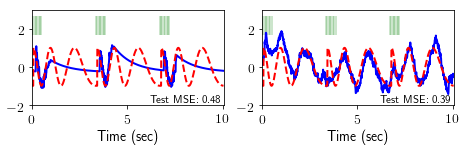

In [63]:
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=14)

# plt.rcParams.update({'font.size': 22})
width = 6.37
height = width / 1.618 / 2
fig = plt.figure()
# fig.subplots_adjust(left=.06, bottom=.16, right=.99, top=.97)
ax1 = fig.add_subplot(121)

nrPeriods = 3

shift = 160
ax1.plot(np.arange(nrPeriods * 335)/100, prediction_test_dict[fileList[0]][shift: shift + nrPeriods * 335], color = 'b',linewidth = 2)
ax1.plot(np.arange(nrPeriods * 335)/100, testTarget[shift: shift + nrPeriods * 335], linestyle = '--', color = 'red', linewidth = 2)
# ax1.plot(np.arange(nrPeriods * 335)/100, pulseSig[:nrPeriods * 335], linestyle = '-', color = 'g', linewidth = 2)
# ax1.eventplot(np.where(pulseSig[:nrPeriods*335] == 2)[0]/100, lineoffsets = 2.2, linelengths = 1, linewidths = 0.4, color = 'k')     


inputSpikes = np.array([])


for i in np.arange(nrPeriods):
    inputSpikes = np.concatenate((inputSpikes, np.linspace(0, 0.5, 8) + i * 3.35 ))

ax1.eventplot(inputSpikes, lineoffsets = 2.2, linelengths = 1, linewidths = 0.4, color = 'g')     



ax1.set_ylim([-2, 3])
ax1.set_xlim([0, 10.05])
ax1.set_xlabel('Time (sec)')
ax1.text(6.2, -1.85, 'Test MSE: ' + str(mse_test_dict[fileList[0]]), fontsize=11)

# ax1.set_ylabel('Time (sec)')

shift = 160
ax2 = fig.add_subplot(122)
ax2.plot(np.arange(nrPeriods * 335)/100, prediction_test_dict[fileList[1]][shift:shift +nrPeriods * 335], color = 'b', linewidth = 2)
ax2.plot(np.arange(nrPeriods * 335)/100, testTarget[shift: shift + nrPeriods * 335], linestyle = '--', color = 'red',  linewidth = 2)
# ax2.plot(np.arange(nrPeriods * 335)/100, pulseSig[:nrPeriods * 335], linestyle = '-', color = 'g', linewidth = 2)
# ax2.eventplot(np.where(pulseSig[:nrPeriods*335] == 2)[0]/100, lineoffsets = 2.2, linelengths = 1, linewidths = 0.4, color = 'k')     
ax2.eventplot(inputSpikes, lineoffsets = 2.2, linelengths = 1, linewidths = 0.4, color = 'g')     

ax2.set_ylim([-2, 3])
ax2.set_xlim([0, 10.05])
ax2.text(6.2, -1.85, 'Test MSE: ' + str(mse_test_dict[fileList[1]]), fontsize=11)

ax2.set_xlabel('Time (sec)')

fig.set_size_inches(width, height)
# fig.subplots_adjust(left=.04, bottom=.05, right=.98, top=.97)

fig.subplots_adjust(left=.06, right=.98, top=.97, bottom = 0.3, wspace=0.2)


# plt.subplots_adjust(bottom = 0.3, wspace=0.1)
plt.gcf().savefig('/Users/liutianlin/Desktop/Academics/MSc_thesis/my_msc_thesis/figs/thesis_regression_test.pdf', dpi=1200)
plt.show()




In [47]:
np.arange(nrPeriods * 335)/100

array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 1.0047e+02, 1.0048e+02,
       1.0049e+02])

In [48]:
nrPeriods * 335

10050

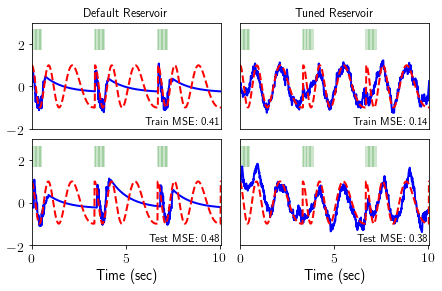

In [23]:
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=14)

# plt.rcParams.update({'font.size': 22})
width = 6.37
height = width / 1.618 
fig = plt.figure()
# fig.subplots_adjust(left=.06, bottom=.16, right=.99, top=.97)
ax1 = fig.add_subplot(221)

nrPeriods = 3

shift = 135

ax1.plot(np.arange(nrPeriods * 335)/100, prediction_train_dict[fileList[0]][shift:shift+nrPeriods * 335], color = 'b',linewidth = 2)
ax1.plot(np.arange(nrPeriods * 335)/100, trainTarget[shift: shift + nrPeriods * 335], linestyle = '--', color = 'red', linewidth = 2)


inputSpikes = np.array([])

for i in np.arange(nrPeriods):
    inputSpikes = np.concatenate((inputSpikes, np.linspace(0, 0.5, 8) + i * 3.35 ))

ax1.eventplot(inputSpikes, lineoffsets = 2.2, linelengths = 1, linewidths = 0.4, color = 'g')     
ax1.set_title('Default Reservoir')



ax1.set_ylim([-2, 3])
ax1.set_xticks([])
# ax1.set_xlabel('Time (sec)')
ax1.text(6, -1.8, 'Train MSE: ' + str(mse_train_dict[fileList[0]]), fontsize=11)
ax1.set_xlim([0, 10.05])

ax2 = fig.add_subplot(222)
ax2.plot(np.arange(nrPeriods * 335)/100, prediction_train_dict[fileList[1]][shift:shift + nrPeriods * 335], color = 'b', linewidth = 2)
ax2.plot(np.arange(nrPeriods * 335)/100, trainTarget[shift: shift + nrPeriods * 335], linestyle = '--', color = 'red',  linewidth = 2)
# ax2.plot(np.arange(nrPeriods * 335)/100, pulseSig[:nrPeriods * 335], linestyle = '-', color = 'g', linewidth = 2)
# ax2.eventplot(np.where(pulseSig[:nrPeriods*335] == 2)[0]/100, lineoffsets = 2.2, linelengths = 1, linewidths = 0.4, color = 'k')     
ax2.eventplot(inputSpikes, lineoffsets = 2.2, linelengths = 1, linewidths = 0.4, color = 'g')     

ax2.set_ylim([-2, 3])
ax2.text(6, -1.8, 'Train MSE: ' + str(mse_train_dict[fileList[1]]), fontsize=11)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xlim([0, 10.05])
ax2.set_title('Tuned Reservoir')


ax3 = fig.add_subplot(223)

shift = 170
ax3.plot(np.arange(nrPeriods * 335)/100, prediction_test_dict[fileList[0]][shift: shift + nrPeriods * 335], color = 'b',linewidth = 2)
ax3.plot(np.arange(nrPeriods * 335)/100, testTarget[shift: shift + nrPeriods * 335], linestyle = '--', color = 'red', linewidth = 2)
# ax3.plot(np.arange(nrPeriods * 335)/100, pulseSig[:nrPeriods * 335], linestyle = '-', color = 'g', linewidth = 2)
# ax3.eventplot(np.where(pulseSig[:nrPeriods*335] == 2)[0]/100, lineoffsets = 2.2, linelengths = 1, linewidths = 0.4, color = 'k')     

ax3.eventplot(inputSpikes, lineoffsets = 2.2, linelengths = 1, linewidths = 0.4, color = 'g')     



ax3.set_ylim([-2, 3])
ax3.set_xlim([0, 10.05])
ax3.set_xlabel('Time (sec)')
ax3.text(6.2, -1.85, 'Test MSE: ' + str(mse_test_dict[fileList[0]]), fontsize=11)

# ax3.set_ylabel('Time (sec)')

ax4 = fig.add_subplot(224)
ax4.plot(np.arange(nrPeriods * 335)/100, prediction_test_dict[fileList[1]][shift:shift +nrPeriods * 335], color = 'b', linewidth = 2)
ax4.plot(np.arange(nrPeriods * 335)/100, testTarget[shift: shift + nrPeriods * 335], linestyle = '--', color = 'red',  linewidth = 2)
# ax4.plot(np.arange(nrPeriods * 335)/100, pulseSig[:nrPeriods * 335], linestyle = '-', color = 'g', linewidth = 2)
# ax4.eventplot(np.where(pulseSig[:nrPeriods*335] == 2)[0]/100, lineoffsets = 2.2, linelengths = 1, linewidths = 0.4, color = 'k')     
ax4.eventplot(inputSpikes, lineoffsets = 2.2, linelengths = 1, linewidths = 0.4, color = 'g')     

ax4.set_ylim([-2, 3])
ax4.set_xlim([0, 10.05])
ax4.text(6.2, -1.85, 'Test MSE: ' + str(mse_test_dict[fileList[1]]), fontsize=11)
ax4.set_yticks([])

ax4.set_xlabel('Time (sec)')

fig.subplots_adjust(left=.06, right=.98, top=.92, bottom = 0.15, hspace = 0.1, wspace=0.1)

# plt.subplots_adjust(bottom = 0.3, wspace=0.1)
plt.gcf().savefig('/Users/liutianlin/Desktop/Academics/MSc_thesis/my_msc_thesis/figs/thesis_regression_combined.pdf', dpi=1200)
plt.show()

